In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import random
import torchaudio
from torch_audiomentations import Compose, PitchShift, Gain
from collections import Counter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
import torch

print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
SAMPLE_RATE = 22050
SEGMENT_LENGTH = 5
N_MELS = 128
HOP_LENGTH = 512
TRAIN_OVERLAP = 0.25
TEST_OVERLAP = 0.0
RANDOM_SEED = 42

AUGMENT = Compose([
    PitchShift(min_transpose_semitones=-2.0, max_transpose_semitones=2.0, p=0.5, sample_rate=SAMPLE_RATE, output_type="tensor"),
    Gain(min_gain_in_db=-6, max_gain_in_db=6, p=0.5, output_type="tensor")
], output_type="tensor")

MEL_TRANSFORM = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=1024
).to(device)


def split_files(real_files, fake_files, test_size=0.2, seed=42):
    random.seed(seed)
    random.shuffle(real_files)
    random.shuffle(fake_files)
    n_real_test = int(len(real_files) * test_size)
    n_fake_test = int(len(fake_files) * test_size)
    return (
        (real_files[n_real_test:], real_files[:n_real_test]),
        (fake_files[n_fake_test:], fake_files[:n_fake_test])
    )


def process_files(file_list, input_dir, output_dir, label, overlap, augment=False):
    os.makedirs(output_dir, exist_ok=True)
    saved_files = []

    segment_samples = SAMPLE_RATE * SEGMENT_LENGTH
    hop_samples = int(segment_samples * (1 - overlap))

    for file in tqdm(file_list):
        file_path = os.path.join(input_dir, file)
        waveform, sr = torchaudio.load(file_path)
        if sr != SAMPLE_RATE:
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        waveform = waveform.to(device)

        total_samples = waveform.shape[1]
        num_segments = max(1, (total_samples - segment_samples) // hop_samples + 1)

        for i in range(num_segments):
            start = i * hop_samples
            end = start + segment_samples
            segment = waveform[:, start:end]

            if segment.shape[1] < segment_samples:
                pad = segment_samples - segment.shape[1]
                segment = torch.nn.functional.pad(segment, (0, pad))

            if augment:
                segment = AUGMENT(segment.unsqueeze(0)).squeeze(0)

            mel_spec = MEL_TRANSFORM(segment)
            mel_spec_db = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10.0, amin=1e-10, db_multiplier=0)

            mel_spec_db -= mel_spec_db.min()
            mel_spec_db /= (mel_spec_db.max() + 1e-8)

            fname = f"{os.path.splitext(file)[0]}_seg{i}.pt"
            save_path = os.path.join(output_dir, fname)
            torch.save(mel_spec_db.cpu(), save_path)
            saved_files.append((fname, label))

    return saved_files

In [7]:
INPUT_DIR = "dataset"
OUTPUT_DIR = "spectrograms"

REAL_DIR = os.path.join(INPUT_DIR, "real")
FAKE_DIR = os.path.join(INPUT_DIR, "fake")

train_dir = os.path.join(OUTPUT_DIR, "train")
test_dir = os.path.join(OUTPUT_DIR, "test")

In [ ]:
real_files = [f for f in os.listdir(REAL_DIR) if f.endswith(".mp3")]
fake_files = [f for f in os.listdir(FAKE_DIR) if f.endswith(".mp3")]

(real_train, real_test), (fake_train, fake_test) = split_files(real_files, fake_files)

In [68]:
import pickle
split = {
    'real_train': real_train,
    'real_test': real_test,
    'fake_train': fake_train,
    'fake_test': fake_test,
}

# Save to file
with open('split.pkl', 'wb') as f:
    pickle.dump(split, f)

In [67]:
print("=== Processing TRAIN ===")
train_files = []
train_files += process_files(real_train, REAL_DIR, train_dir, label=0, overlap=TRAIN_OVERLAP, augment=True)
train_files += process_files(fake_train, FAKE_DIR, train_dir, label=1, overlap=TRAIN_OVERLAP, augment=True)

=== Processing TRAIN ===


100%|██████████| 8000/8000 [54:44<00:00,  2.44it/s]  


In [43]:
train_labels = [label for _, label in train_files]
n_real_train = sum(1 for l in train_labels if l == 0)
n_fake_train = sum(1 for l in train_labels if l == 1)


print(f"Train: Real = {n_real_train}, Fake = {n_fake_train}")

Train: Real = 465628, Fake = 334387


In [31]:
import pickle
with open("split.pkl", "rb") as f:
    split = pickle.load(f)

real_test = split["real_test"]
fake_test = split["fake_test"]
real_train = split['real_train']
print(real_train)

['8NnQs3EtoqU.mp3', 'ed3dSyh00Qg.mp3', 'IZgqMpkSwqA.mp3', 'R9Z03WqSytk.mp3', 'G2fzvTGIxNk.mp3', 'F0TfSK3Izc8.mp3', 'iubLxy21jzM.mp3', 'TEezDy6Byws.mp3', 'nrMZOy6s0tU.mp3', 'wwlmaPBrlTU.mp3', 'QZfdJx8Z1yw.mp3', 'mnq-ACaMHds.mp3', 'oSdP3RvApp8.mp3', 'gOlwNZ0LpHw.mp3', 'StUYHGDJUbQ.mp3', 'fzVMb-VPePs.mp3', 'CeQBxL_fUY4.mp3', 'M0NAgiwfe9c.mp3', '4tJicYT8R90.mp3', 'dFyu7pYs21o.mp3', 'HMKaM3FdsgY.mp3', '18hQz4lfKB4.mp3', 'x01uHnALSmo.mp3', 'NLGM2wKSx_s.mp3', 'CHOacjBkUOM.mp3', 'J-B_NuUz8uI.mp3', '-uXODw3s1Mo.mp3', 'aMKtzB7zNrg.mp3', 'jCBOkG7zQPM.mp3', 'G9cnvPaOJ9E.mp3', 'DvOWfGGtX_U.mp3', '3ebx8d8DKxA.mp3', 'DB3nEesYdcE.mp3', 'E-fGq5fHQpY.mp3', '_dXV2vyJoYc.mp3', 'v0i5gt6Y8KU.mp3', 'Z1rxu-ZxvBk.mp3', 'YEI2IAyoBZI.mp3', 'N3ggVlnICKM.mp3', 'ua1CloWBgNo.mp3', 'vEkLy7A37T0.mp3', '5710OAhwkUw.mp3', 'degO5yY2DOQ.mp3', 'dDFGYW9ZYIg.mp3', 'nrzIVP3-dyc.mp3', 'en2AK9fj1zs.mp3', 'R1PFJ7obBfk.mp3', '_lKVfZ0RthQ.mp3', 'tWFmbq2mWaQ.mp3', 'lzz0SBkcebc.mp3', 'zaDkOfvwWzc.mp3', 'bbbIKveC3HE.mp3', '1nPDEMpHCa

In [8]:
print("=== Processing TEST ===")
test_files = []
test_files += process_files(real_test, REAL_DIR, test_dir, label=0, overlap=TEST_OVERLAP, augment=False)
test_files += process_files(fake_test, FAKE_DIR, test_dir, label=1, overlap=TEST_OVERLAP, augment=False)

=== Processing TEST ===


100%|██████████| 2000/2000 [05:52<00:00,  5.68it/s]


NameError: name 'test_files' is not defined

In [10]:
test_labels = [label for _, label in test_files]
n_real_test = sum(1 for l in test_labels if l == 0)
n_fake_test = sum(1 for l in test_labels if l == 1)


print(f"Train: Real = {n_real_test}, Fake = {n_fake_test}")

Train: Real = 87201, Fake = 63389


In [9]:
print(f"Train: {len(real_train)} real, {len(fake_train)} fake | Test: {len(real_test)} real, {len(fake_test)} fake")

NameError: name 'real_train' is not defined

In [20]:
# Load your original split
with open("split.pkl", "rb") as f:
    old_split = pickle.load(f)

# Now, convert to new format:
# Each list will be: [(filename, label)]

new_split = {"train": [], "test": []}

# Real train => label 0
new_split["train"].extend([(fname, 0) for fname in old_split["real_train"]])
# Fake train => label 1
new_split["train"].extend([(fname, 1) for fname in old_split["fake_train"]])

# Same for test
new_split["test"].extend([(fname, 0) for fname in old_split["real_test"]])
new_split["test"].extend([(fname, 1) for fname in old_split["fake_test"]])

# Save new split
with open("new_split.pkl", "wb") as f:
    pickle.dump(new_split, f)

print("✅ Saved new_split.pkl with labels attached.")

✅ Saved new_split.pkl with labels attached.


In [18]:
import os
import pickle
import shutil
from tqdm import tqdm

# === Load split.pkl ===
with open('split.pkl', 'rb') as f:
    split = pickle.load(f)

base_dir = "spectrograms"

# Make sure subfolders exist
for split_name in ["train", "test"]:
    for cls in ["real", "fake"]:
        os.makedirs(os.path.join(base_dir, split_name, cls), exist_ok=True)

# === Helper: create sets of base names ===
# Remove extensions (.mp3/.wav) so they match your .pt base names
real_train_bases = {os.path.splitext(f)[0] for f in split['real_train']}
fake_train_bases = {os.path.splitext(f)[0] for f in split['fake_train']}
real_test_bases  = {os.path.splitext(f)[0] for f in split['real_test']}
fake_test_bases  = {os.path.splitext(f)[0] for f in split['fake_test']}

# === Organize files ===
for split_name in ["train", "test"]:
    folder = os.path.join(base_dir, split_name)
    print(f"\nOrganizing {split_name} ...")

    for fname in tqdm(os.listdir(folder)):
        full_path = os.path.join(folder, fname)
        # Skip subfolders
        if os.path.isdir(full_path):
            continue

        # Extract base: remove '_seg...' and '.pt'
        base = fname.split("_seg")[0].replace(".pt", "")

        # Decide target
        if split_name == "train":
            if base in real_train_bases:
                dest = os.path.join(folder, "real", fname)
            elif base in fake_train_bases:
                dest = os.path.join(folder, "fake", fname)
            else:
                continue  # no match
        else:
            if base in real_test_bases:
                dest = os.path.join(folder, "real", fname)
            elif base in fake_test_bases:
                dest = os.path.join(folder, "fake", fname)
            else:
                continue  # no match

        shutil.move(full_path, dest)

print("\n✅ Done! Files now organized into:")
print("""
spectrograms/
  ├── train/
  │   ├── real/
  │   ├── fake/
  ├── test/
  │   ├── real/
  │   ├── fake/
""")



Organizing train ...


100%|██████████| 797768/797768 [24:44<00:00, 537.49it/s]  



Organizing test ...


100%|██████████| 150592/150592 [03:16<00:00, 764.86it/s] 


✅ Done! Files now organized into:

spectrograms/
  ├── train/
  │   ├── real/
  │   ├── fake/
  ├── test/
  │   ├── real/
  │   ├── fake/



In [2]:
class CNNClassifier(nn.Module):
    def __init__(self, n_mels=128, time_steps=216):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(2),
            
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            nn.MaxPool2d(2),
            
            # # Layer 3
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.01, inplace=True),
            # nn.MaxPool2d(2),
        )
        
        # Calculate flattened dimensions
        with torch.no_grad():
            dummy = torch.randn(1, 1, n_mels, time_steps)
            dummy_out = self.conv_layers(dummy)
            self.flattened_dim = dummy_out.numel() // dummy_out.size(0)
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            # nn.Sigmoid()  # Remove if using BCEWithLogitsLoss
        )
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)


In [3]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, num_classes=1):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.squeeze(1)  # (B, 128, 216) from (B, 1, 128, 216)
        x = x.permute(0, 2, 1)  # (B, 216, 128): [batch, time, features]
        out, _ = self.lstm(x)  # (B, 216, hidden*2)
        out = out[:, -1, :]  # Use last time step
        out = self.fc(out)
        return out


In [4]:
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=(16, 16), embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, N_patches, embed_dim)
        return x

class AudioTransformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=4, num_classes=1):
        super(AudioTransformer, self).__init__()
        self.embedding = PatchEmbedding(embed_dim=embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.fc = nn.Linear(embed_dim, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B = x.size(0)
        x = self.embedding(x)  # (B, N, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, embed_dim)
        x = self.transformer(x)
        x = self.fc(x[:, 0])  # Use cls_token output
        return x


In [46]:
print(len(os.listdir("spectrograms/train/real")))

463197


In [48]:
import os
import pickle
import re

def get_base(fname):
    return re.split(r"_seg\d+", fname)[0]

# === Load original split ===
with open('split.pkl', 'rb') as f:
    split = pickle.load(f)

real_train = split['real_train']
fake_train = split['fake_train']
real_test = split['real_test']
fake_test = split['fake_test']

# === Helper: strip extension ===
def base_name(f):
    return os.path.splitext(f)[0]

real_train_base = set(base_name(f) for f in real_train)
fake_train_base = set(base_name(f) for f in fake_train)
real_test_base = set(base_name(f) for f in real_test)
fake_test_base = set(base_name(f) for f in fake_test)

print(f"Real train base: {len(real_train_base)}")
print(f"Fake train base: {len(fake_train_base)}")

print(real_train_base)

import os

def collect_segments(data_dir, real_base, fake_base):
    files = []
    labels = []
    # Look inside real/ and fake/ folders
    for label_folder, label_value, base_set in [
        ('real', 0, real_base),
        ('fake', 1, fake_base)
    ]:
        folder_path = os.path.join(data_dir, label_folder)
        for fname in os.listdir(folder_path):
            if not fname.endswith(".pt"):
                continue
            base = get_base(fname)
            if base in base_set:
                files.append(os.path.join(label_folder, fname))  # include subfolder in path!
                labels.append(label_value)
    return files, labels


train_files, train_labels = collect_segments("spectrograms/train", real_train_base, fake_train_base)
test_files, test_labels = collect_segments("spectrograms/test", real_test_base, fake_test_base)

print(f"Train: {len(train_files)} segments")
print(f"Test: {len(test_files)} segments")


# === Save new split ===
split_segments = {
    'train_files': train_files,
    'train_labels': train_labels,
    'test_files': test_files,
    'test_labels': test_labels
}

with open('split_segments.pkl', 'wb') as f:
    pickle.dump(split_segments, f)

print("✅ New segment-level split saved to split_segments.pkl")


Real train base: 8000
Fake train base: 8000
{'1qNVMpW91pU', 'Yt0XAvb3Itc', '8ZzQEmVgw-k', 'LHUKKrcXfJs', 'dXnzVhdYL9g', 'ClijKX0uDmQ', 'LDzRipRMsZU', 'yaS3vaNUYgs', 'ekTei2yY4EI', '6ffcpcQEU8s', '7iJ7oj-dAVY', '2hIBCCXISe8', 'KIhaSBYVRNM', 'AIKP2aQCKrM', 'Z3q5UrpQLQI', 'TMX-MihJtHo', 'mekHa3cEuY4', 'GWaRHvGawNc', 'SOscjUHPY-o', 'ihV7B_H1_KE', 'GTrk8U9gqC0', 'nyuo9-OjNNg', 'mnq-ACaMHds', 'hIrnchu0PNc', 'HYFqCE5YB7E', 'ywr0XJ4Lu_8', 'NPHW2Co-bZQ', 'fbtXoRWUzPc', 'pstVCGyaUBM', 'x8mWpr9Ghg4', 'Ju7b8dh9yWA', 'Aj8T-Rk5Ei8', 'wjOrmSEQDwg', 'BTA6zBU0-4k', 'Wu7i27gZWXA', 'cpJ5JIscnLs', 'stsdZvryy3I', '2VRDZJGzjnQ', 'xxBvZME7xB4', '6etaPWnHFQI', 'Xc9H5tF9ko8', 'CJOZc02VwJM', '6JnFTRbLYTc', 'CJgPAnmAT_Q', '3tQn86-_H-I', 'CbMmcc8yunc', 'NsvSWLtUxHk', 'R9Z03WqSytk', 'JJUitwQA_uU', 'geannzZqCzY', '8NbHVkpv3-s', 'CwnZI01YdXE', '5cov3OyQ6fI', 'bTr5Qkn4jkQ', '8SjLGOMtTWA', 'U6bZHPYQCmA', '0HcH2TRsB6g', 'xuccTS0xLtc', 'KFISgeHIc7E', 'Z_jb-16S3o4', 'xgesPWGUigU', 'Km__cJEJ3JI', 'qVCme_D7pV4', 'Xq-bSIKMV

In [3]:
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, split_file, split_name, data_dir):
        with open(split_file, 'rb') as f:
            split = pickle.load(f)

        if split_name == 'train':
            self.files = split['train_files']
            self.labels = split['train_labels']
        elif split_name == 'test':
            self.files = split['test_files']
            self.labels = split['test_labels']
        else:
            raise ValueError("split_name must be 'train' or 'test'")

        self.data_dir = data_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        x = torch.load(os.path.join(self.data_dir, self.files[idx]))
        y = torch.tensor(self.labels[idx], dtype=torch.float)
        return x, y


In [6]:
import numpy as np

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
# === Create datasets ===
train_dataset = SpectrogramDataset(
    split_file='split_segments.pkl',
    split_name='train',
    data_dir='spectrograms/train'
)
print(f"Train dataset size: {len(train_dataset)}")
val_dataset = SpectrogramDataset(
    split_file='split_segments.pkl',
    split_name='test',
    data_dir='spectrograms/test'
)
print(f"Test dataset size: {len(val_dataset)}")
# Make sure train_labels is LONG type for indexing
train_labels = torch.tensor(train_dataset.labels, dtype=torch.long)

# Compute class counts
class_sample_count = torch.tensor([
    (train_labels == 0).sum(),
    (train_labels == 1).sum()
], dtype=torch.float)

# Compute inverse class weights
class_weights = 1.0 / class_sample_count

print(f"Class counts: {class_sample_count.tolist()}")
print(f"Class weights: {class_weights.tolist()}")

# ✅ Indexing works now: labels must be long
sample_weights = class_weights[train_labels]

# === Weighted Sampler ===
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# === DataLoaders ===
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler,   # balanced sampling
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,     # no shuffle for validation!
    num_workers=0,
    pin_memory=True
)


Train dataset size: 797766
Test dataset size: 150590
Class counts: [463197.0, 334569.0]
Class weights: [2.158908728233655e-06, 2.988920186908217e-06]


In [11]:
from collections import Counter

counts = Counter()
num_batches = 30

for i, (_, labels) in enumerate(train_loader):
    c = Counter(labels.tolist())
    counts[0] += c[0]
    counts[1] += c[1]
    if i + 1 >= num_batches:
        break

total = counts[0] + counts[1]
print(f"Sampled {total} examples over {num_batches} batches")
print(f"Real: {counts[0]} ({counts[0]/total:.2%})")
print(f"Fake: {counts[1]} ({counts[1]/total:.2%})")


Sampled 1920 examples over 30 batches
Real: 964 (50.21%)
Fake: 956 (49.79%)


In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    # Initialize utilities
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    early_stopping = EarlyStopping(patience=3, verbose=True)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lrs': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print(outputs.shape, labels.shape)
            # Backward pass
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # if torch.isnan(loss):
            #     raise ValueError("Loss is NaN. Check input data or model stability.")
            optimizer.step()
            
            # Metrics
            train_loss += loss.item()
            train_correct += ((outputs > 0.5).float() == labels).sum().item()
            pbar.set_postfix({'loss': loss.item()})

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_correct += ((outputs > 0.5).float() == labels).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(test_loader)
        val_acc = val_correct / len(test_loader.dataset)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lrs'].append(optimizer.param_groups[0]['lr'])

        # Print epoch summary
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Stopping training early")
            break

    return model, history

In [9]:
# --- Main ---
if __name__ == "__main__":
    # Initialize and train

    model = AudioTransformer().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    criterion = torch.nn.BCEWithLogitsLoss()
    trained_model, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        epochs=10
    )

Epoch 1/10: 100%|██████████| 12466/12466 [39:42<00:00,  5.23it/s, loss=0.546]   



Epoch 1:
Train Loss: 0.0388 | Acc: 0.9848
Val Loss: 0.0076 | Acc: 0.9979
LR: 1.00e-04
Validation loss decreased (inf --> 0.007567). Saving model...


Epoch 2/10: 100%|██████████| 12466/12466 [40:47<00:00,  5.09it/s, loss=0.000159]



Epoch 2:
Train Loss: 0.0145 | Acc: 0.9948
Val Loss: 0.0062 | Acc: 0.9982
LR: 1.00e-04
Validation loss decreased (0.007567 --> 0.006207). Saving model...


Epoch 3/10: 100%|██████████| 12466/12466 [41:01<00:00,  5.06it/s, loss=0.00115] 



Epoch 3:
Train Loss: 0.0111 | Acc: 0.9960
Val Loss: 0.0014 | Acc: 0.9996
LR: 1.00e-04
Validation loss decreased (0.006207 --> 0.001424). Saving model...


Epoch 4/10: 100%|██████████| 12466/12466 [40:41<00:00,  5.11it/s, loss=0.000137]



Epoch 4:
Train Loss: 0.0094 | Acc: 0.9966
Val Loss: 0.0011 | Acc: 0.9997
LR: 1.00e-04
Validation loss decreased (0.001424 --> 0.001067). Saving model...


Epoch 5/10: 100%|██████████| 12466/12466 [40:35<00:00,  5.12it/s, loss=2.54e-5] 



Epoch 5:
Train Loss: 0.0079 | Acc: 0.9972
Val Loss: 0.0029 | Acc: 0.9991
LR: 1.00e-04
EarlyStopping counter: 1 out of 3


Epoch 6/10: 100%|██████████| 12466/12466 [40:30<00:00,  5.13it/s, loss=5.22e-5] 



Epoch 6:
Train Loss: 0.0072 | Acc: 0.9975
Val Loss: 0.0020 | Acc: 0.9995
LR: 1.00e-04
EarlyStopping counter: 2 out of 3


Epoch 7/10: 100%|██████████| 12466/12466 [40:19<00:00,  5.15it/s, loss=1.97e-5] 



Epoch 7:
Train Loss: 0.0064 | Acc: 0.9977
Val Loss: 0.0026 | Acc: 0.9993
LR: 1.00e-04
EarlyStopping counter: 3 out of 3
Stopping training early


In [10]:
model.eval()  # Set to evaluation mode
test_loss = 0.0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Match model output shape
        
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(val_loader)
accuracy = correct / len(val_loader.dataset)

print(f"\nFinal Test Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {accuracy:.4f}")


Final Test Results:
Loss: 0.0026 | Accuracy: 0.9993


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).cpu().numpy()

            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_preds)

# Example usage
true_labels, predicted_labels = evaluate_model(model, val_loader, device='cuda')

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))


Confusion Matrix:
[[87103    98]
 [    7 63382]]

Classification Report:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     87201
        fake       1.00      1.00      1.00     63389

    accuracy                           1.00    150590
   macro avg       1.00      1.00      1.00    150590
weighted avg       1.00      1.00      1.00    150590



Saving & Loading Model

In [12]:
import os
import datetime
import json
import torch

def save_model(model, optimizer, results, save_dir="saved_models", additional_metadata=None):
    """
    Enhanced model saving function that:
    - Creates timestamped directories
    - Saves full training state
    - Stores metadata and training history in separate JSON files
    - Includes model architecture and optimizer state
    """
    
    run_dir = os.path.join(save_dir, f"model_AST_part2")
    os.makedirs(run_dir, exist_ok=True)

    # --- 1. Metadata ---
    metadata = {
        "model_name": "FakeMusicDetector",
        "date": datetime.datetime.now().isoformat(),
        "input_shape": (1, 128, 216),  # Update with actual input shape
        "training_results": {
            "best_val_loss": results.get('best_val_loss', None),
            "final_train_loss": results.get('train_loss', [-1])[-1],
            "final_val_loss": results.get('val_loss', [-1])[-1],
            "final_train_acc": results.get('train_acc', [-1])[-1],
            "final_val_acc": results.get('val_acc', [-1])[-1],
        },
        "classes": ["real", "fake"],
        "model_architecture": str(model),
        "training_params": {
            "optimizer": type(optimizer).__name__,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "weight_decay": optimizer.param_groups[0].get('weight_decay', 0),
        }
    }

    if additional_metadata:
        metadata.update(additional_metadata)

    # --- 2. Save PyTorch Checkpoint ---
    model_path = os.path.join(run_dir, "model_checkpoint.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_architecture': metadata['model_architecture'],
        'metadata': metadata
    }, model_path)

    # --- 3. Save Metadata as JSON ---
    metadata_path = os.path.join(run_dir, "training_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    # --- 4. Save Training History Separately ---
    history_path = os.path.join(run_dir, "training_history.json")
    history_to_save = {
        'train_loss': results.get('train_loss', []),
        'val_loss': results.get('val_loss', []),
        'train_acc': results.get('train_acc', []),
        'val_acc': results.get('val_acc', []),
        'lrs': results.get('lrs', [])
    }
    with open(history_path, 'w') as f:
        json.dump(history_to_save, f, indent=4)

    # --- 5. Optionally Save Full Model (Pickle-Based) ---
    full_model_path = os.path.join(run_dir, "model_full.pth")
    torch.save(model, full_model_path)

    print(f"\n✅ Model and training artifacts saved to: {run_dir}")
    print(f"📁 model_checkpoint.pth")
    print(f"📄 training_metadata.json")
    print(f"📈 training_history.json")
    print(f"📦 model_full.pth")

    return run_dir
save_model(model, optimizer, history)


✅ Model and training artifacts saved to: saved_models\model_AST_part2
📁 model_checkpoint.pth
📄 training_metadata.json
📈 training_history.json
📦 model_full.pth


'saved_models\\model_AST_part2'

In [14]:
import json

def load_model(save_dir, model_class=None, optimizer_class=None, use_full_model=False, device='cpu'):
    """
    Load a model and optionally its optimizer and metadata.

    Args:
        save_dir (str): Directory where model files are saved.
        model_class (callable, optional): The model class to initialize (required for checkpoint mode).
        optimizer_class (callable, optional): Optimizer class to load state into (optional).
        use_full_model (bool): If True, loads full model file directly (less flexible).
        device (str): 'cpu' or 'cuda'.

    Returns:
        model, optimizer (or None), metadata (dict)
    """
    device = torch.device(device)
    metadata_path = os.path.join(save_dir, "training_metadata.json")
    checkpoint_path = os.path.join(save_dir, "model_checkpoint.pth")
    full_model_path = os.path.join(save_dir, "model_full.pth")

    # Load metadata
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata file not found at: {metadata_path}")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    # Load full model
    if use_full_model:
        if not os.path.exists(full_model_path):
            raise FileNotFoundError(f"Full model file not found at: {full_model_path}")
        model = torch.load(full_model_path, map_location=device)
        model.to(device)
        model.eval()
        return model, None, metadata

    # Load from checkpoint (preferred)
    if model_class is None:
        raise ValueError("model_class must be provided when loading from checkpoint.")
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found at: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Restore model
    model = model_class()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Restore optimizer if needed
    optimizer = None
    if optimizer_class is not None:
        optimizer = optimizer_class(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer, metadata

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).cpu().numpy()

            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_preds)

loaded_model, optimizer, metadata = load_model(
    save_dir="saved_models/model_CNN_part3",
    model_class=CNNClassifier,
    optimizer_class=torch.optim.AdamW,
    use_full_model=False,
    device='cuda'  # or 'cpu'
)
# Example usage
true_labels, predicted_labels = evaluate_model(loaded_model, val_loader, device='cuda')

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))


Confusion Matrix:
[[87189    12]
 [    0 63389]]

Classification Report:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     87201
        fake       1.00      1.00      1.00     63389

    accuracy                           1.00    150590
   macro avg       1.00      1.00      1.00    150590
weighted avg       1.00      1.00      1.00    150590



In [17]:
loaded_model, optimizer, metadata = load_model(
    save_dir="saved_models/model_AST_part2",
    model_class=AudioTransformer,
    optimizer_class=torch.optim.AdamW,
    use_full_model=False,
    device='cuda'  # or 'cpu'
)
# Example usage
true_labels, predicted_labels = evaluate_model(loaded_model, val_loader, device='cuda')

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))


Confusion Matrix:
[[87103    98]
 [    7 63382]]

Classification Report:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     87201
        fake       1.00      1.00      1.00     63389

    accuracy                           1.00    150590
   macro avg       1.00      1.00      1.00    150590
weighted avg       1.00      1.00      1.00    150590



Loaded model: FakeMusicDetectorAST


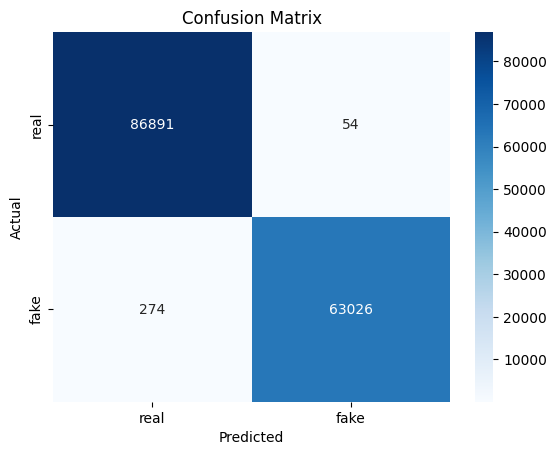


Classification Report AST:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     86945
        fake       1.00      1.00      1.00     63300

    accuracy                           1.00    150245
   macro avg       1.00      1.00      1.00    150245
weighted avg       1.00      1.00      1.00    150245

Loaded model: FakeMusicDetectorCNN


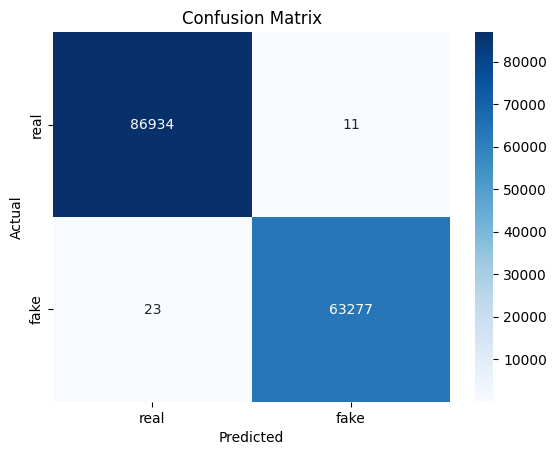


Classification Report CNN:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     86945
        fake       1.00      1.00      1.00     63300

    accuracy                           1.00    150245
   macro avg       1.00      1.00      1.00    150245
weighted avg       1.00      1.00      1.00    150245

Loaded model: FakeMusicDetectorBiLSTM


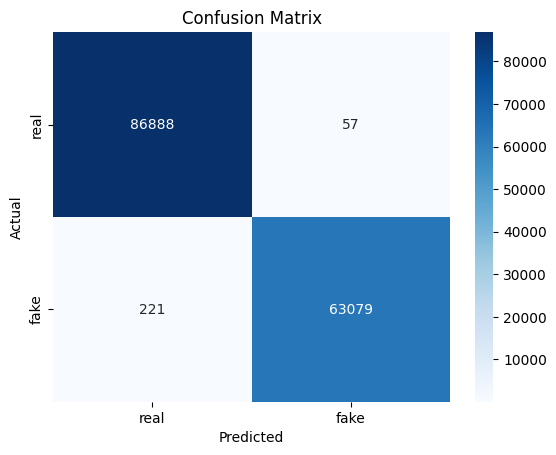


Classification Report BiLSTM:
              precision    recall  f1-score   support

        real       1.00      1.00      1.00     86945
        fake       1.00      1.00      1.00     63300

    accuracy                           1.00    150245
   macro avg       1.00      1.00      1.00    150245
weighted avg       1.00      1.00      1.00    150245



In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

model_dir_AST = "saved_models/model_AST"
loaded_model, optimizer, metadata = load_model(
    save_dir=model_dir_AST,
    model_class=AudioTransformer,
    optimizer_class=torch.optim.AdamW,
    use_full_model=False,
    device='cuda'  # or 'cpu'
)

print("Loaded model:", metadata["model_name"])

true_labels, predicted_labels = evaluate_model(loaded_model, test_loader, device='cuda')

labels = ['real', 'fake']
sns.heatmap(confusion_matrix(true_labels, predicted_labels),fmt='d', annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix AST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report AST:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))

model_dir_CNN = "saved_models/model_CNN"
loaded_model, optimizer, metadata = load_model(
    save_dir=model_dir_CNN,
    model_class=CNNClassifier,
    optimizer_class=torch.optim.AdamW,
    use_full_model=False,
    device='cuda'  # or 'cpu'
)

print("Loaded model:", metadata["model_name"])

true_labels, predicted_labels = evaluate_model(loaded_model, test_loader, device='cuda')

labels = ['real', 'fake']
sns.heatmap(confusion_matrix(true_labels, predicted_labels),fmt='d', cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report CNN:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))

model_dir_BiLSTM = "saved_models/model_BiLSTM"
loaded_model, optimizer, metadata = load_model(
    save_dir=model_dir_BiLSTM,
    model_class=BiLSTMClassifier,
    optimizer_class=torch.optim.AdamW,
    use_full_model=False,
    device='cuda'  # or 'cpu'
)

print("Loaded model:", metadata["model_name"])

true_labels, predicted_labels = evaluate_model(loaded_model, test_loader, device='cuda')

labels = ['real', 'fake']
sns.heatmap(confusion_matrix(true_labels, predicted_labels),fmt='d', cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report BiLSTM:")
print(classification_report(true_labels, predicted_labels, target_names=["real", "fake"]))

In [18]:
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item()
            total_correct += ((outputs > 0.5).float() == labels).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

# Load your saved model (if needed)
# model.load_state_dict(torch.load('model.pth'))

criterion = nn.BCELoss()
train_loss, train_acc = evaluate_model(loaded_model, train_loader, criterion)
test_loss, test_acc = evaluate_model(loaded_model, test_loader, criterion)

print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Check for overfitting
if train_acc > test_acc + 0.15:  # Large gap suggests overfitting
    print("⚠️ Model may be overfitting (train accuracy much higher than test).")
elif test_loss > train_loss:
    print("⚠️ Model may be overfitting (test loss higher than train loss).")
else:
    print("✅ Model seems to generalize well.")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


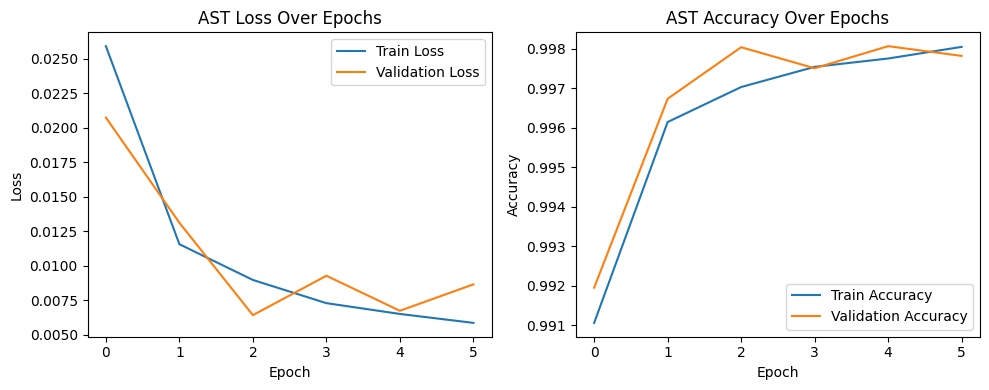

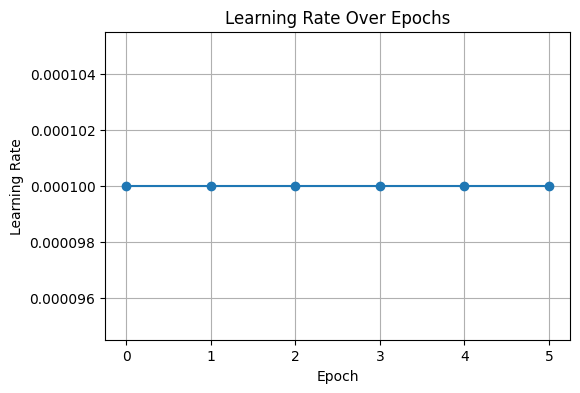

In [18]:
import json
import matplotlib.pyplot as plt

# Path to your saved history
history_path = "saved_models/model_AST/training_history.json"

# Load history from JSON
with open(history_path, 'r') as f:
    history = json.load(f)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("AST Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title("AST Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['lrs'], marker='o')
plt.title("Learning Rate Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()



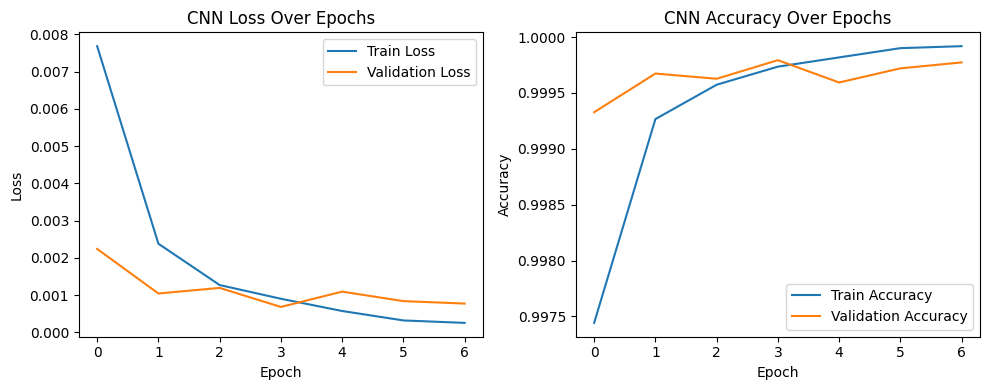

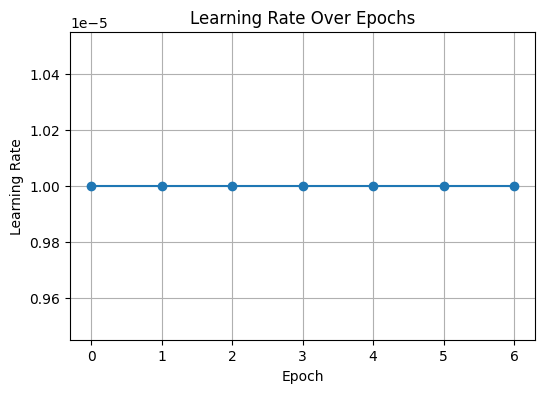

In [23]:
# Path to your saved history
history_path = "saved_models/model_CNN/training_history.json"

# Load history from JSON
with open(history_path, 'r') as f:
    history = json.load(f)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("CNN Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title("CNN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['lrs'], marker='o')
plt.title("Learning Rate Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


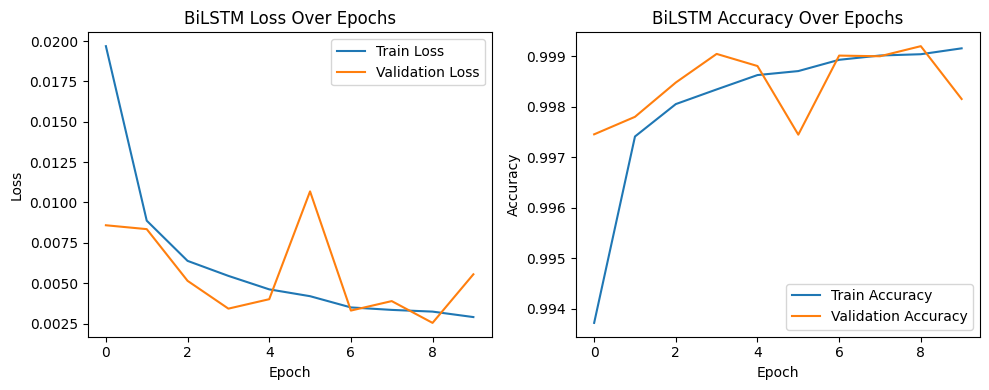

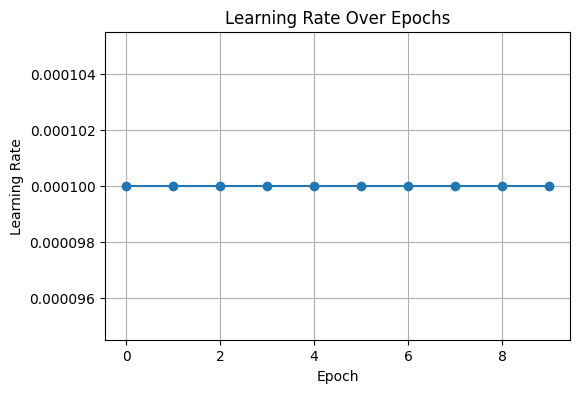

In [24]:
# Path to your saved history
history_path = "saved_models/model_BiLSTM/training_history.json"

# Load history from JSON
with open(history_path, 'r') as f:
    history = json.load(f)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("BiLSTM Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title("BiLSTM Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['lrs'], marker='o')
plt.title("Learning Rate Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


In [27]:
import hashlib
import numpy as np

def compute_checksum(tensor):
    # Convert tensor to bytes and compute MD5 (faster than Python's hash)
    np_array = tensor.numpy()
    return hashlib.md5(np_array.tobytes()).hexdigest()

# Extract tensors and corresponding file paths directly from indices
train_indices = balanced_indices
test_indices = test_indices  # Already defined earlier

train_checksums = []
checksum_to_file_train = {}
for i in train_indices:
    tensor, _ = dataset[i]
    checksum = compute_checksum(tensor)
    train_checksums.append(checksum)
    checksum_to_file_train[checksum] = dataset.all_files[i]

test_checksums = []
checksum_to_file_test = {}
for i in test_indices:
    tensor, _ = dataset[i]
    checksum = compute_checksum(tensor)
    test_checksums.append(checksum)
    checksum_to_file_test[checksum] = dataset.all_files[i]

# Find overlap
overlapping_checksums = set(train_checksums) & set(test_checksums)
print(f"Overlapping samples: {len(overlapping_checksums)}")
print("Overlapping samples and their source files:")
for checksum in overlapping_checksums:
    print("Train file:", checksum_to_file_train.get(checksum))
    print("Test file: ", checksum_to_file_test.get(checksum))


Overlapping samples: 0
Overlapping samples and their source files:


fake_04300_suno_0_seg38.npy
fake_00719_suno_1_seg38.npy

./dataset/spectrograms/real\_wVB6pfWwnE_seg40.npy
./dataset/spectrograms/real\56bU7xAU1tM_seg54.npy

Equal? True


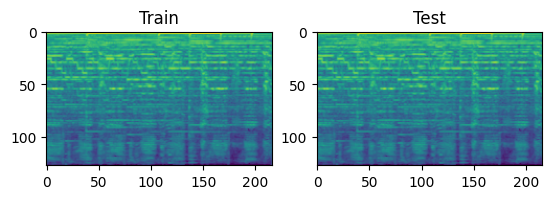

AttributeError: module 'matplotlib' has no attribute 'pyplot'

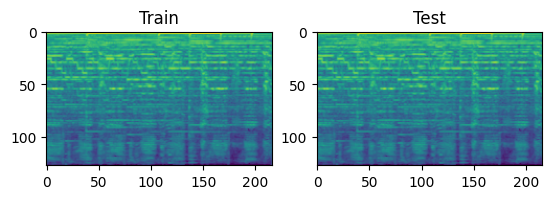

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [22]:
import matplotlib.pyplot as plt

def compare_tensors(train_path, test_path):
    a = np.load(train_path)
    b = np.load(test_path)
    print("Equal?", np.array_equal(a, b))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plt.imshow(a)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plt.imshow(b)
    plt.show()

compare_tensors("./dataset/spectrograms/real\jlCxltV3Xyo_seg33.npy", "./dataset/spectrograms/real/5LEJgh4ykV8_seg33.npy")

In [ ]:
def predict(spec_path, model, device='cuda'):
    # Load and preprocess spectrogram
    spec = np.load(spec_path)
    spec = (spec - 0.5) / 0.5  # Same as training
    spec_tensor = torch.FloatTensor(spec).unsqueeze(0).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        prob = model(spec_tensor).item()
    
    return "Fake" if prob > 0.5 else "Real", prob

# Usage:
prediction, confidence = predict("dataset/spectrograms/fake", loaded_model)
print(f"Prediction: {prediction} (Confidence: {confidence:.2%})")

VISUALIZATION

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
fold_metrics = {'acc': [], 'f1': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold+1}")
    
    # Create data loaders
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
    
    # Train and evaluate
    model = CNNClassifier().to(device)
    train_model(model, train_loader, val_loader, epochs=5)  # Your training function
    acc, f1 = evaluate(model, val_loader)  # Your evaluation function
    
    fold_metrics['acc'].append(acc)
    fold_metrics['f1'].append(f1)

print(f"\nAverage across folds: Accuracy={np.mean(fold_metrics['acc']):.2f}, F1={np.mean(fold_metrics['f1']):.2f}")

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_predictions(model, test_loader, num_samples=5, device='cpu'):
    model.eval()
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))
    
    # If only one sample, axes will be 1D, so we need to make it 2D for consistency
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            pred = outputs.squeeze().item()
            
            # Plot spectrogram
            ax = axes[i, 0]
            spec = inputs[0].squeeze().cpu().numpy()
            im = ax.imshow(spec, aspect='auto', origin='lower')
            plt.colorbar(im, ax=ax)
            ax.set_title(f"True: {'Fake' if labels[0].item() else 'Real'}\nPred: {pred:.2f} ({'Fake' if pred > 0.5 else 'Real'})")
            
            # Plot prediction distribution
            ax = axes[i, 1]
            ax.bar(['Real', 'Fake'], [1-pred, pred], color=['green', 'red'])
            ax.set_ylim(0, 1)
            ax.set_ylabel('Probability')
            
    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions(loaded_model, test_loader, num_samples=3)

AttributeError: module 'matplotlib' has no attribute 'axes'

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [ ]:
def plot_training_history(train_losses, test_losses, train_accs, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train')
    ax1.plot(test_losses, label='Test')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train')
    ax2.plot(test_accs, label='Test')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()

# Usage (assuming you tracked these during training)
plot_training_history(train_loss_history, test_loss_history, train_acc_history, test_acc_history)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    probs = []
    labels = []
    
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            probs.extend(output.cpu().numpy())
            labels.extend(label.cpu().numpy())
    
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, test_loader)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_feature_space(model, test_loader, method='pca'):
    model.eval()
    features = []
    target_labels = []
    
    # Extract features from penultimate layer
    def hook(module, input, output):
        features.extend(output.cpu().numpy())
    
    hook_handle = model.fc_layers[-3].register_forward_hook(hook)  # Adjust layer index
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            _ = model(inputs)
            target_labels.extend(labels.cpu().numpy())
    
    hook_handle.remove()
    
    # Dimensionality reduction
    features = np.array(features)
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2)
    
    embeddings = reducer.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(10,8))
    scatter = plt.scatter(embeddings[:,0], embeddings[:,1], c=target_labels, alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(f'{method.upper()} Projection of Feature Space')
    plt.show()

visualize_feature_space(model, test_loader, method='tsne')

In [ ]:
def plot_class_activation(model, spec_path):
    # Load model and spectrogram
    spec = np.load(spec_path)
    spec_tensor = torch.FloatTensor((spec - 0.5) / 0.5).unsqueeze(0).unsqueeze(0).to(device)
    
    # Hook for last conv layer
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    hook = model.conv_layers[-3].register_forward_hook(get_activation('last_conv'))
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(spec_tensor)
    
    hook.remove()
    
    # Process activations
    act = activation['last_conv'].squeeze().cpu().numpy()
    cam = act.mean(axis=0)  # Average across channels
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    # Original spectrogram
    ax1.imshow(spec, aspect='auto', origin='lower')
    ax1.set_title('Original Spectrogram')
    
    # Class activation
    ax2.imshow(cam, aspect='auto', origin='lower')
    ax2.set_title('Class Activation Map')
    
    plt.colorbar(ax2.imshow(cam, aspect='auto', origin='lower'), ax=ax2)
    plt.suptitle(f"Prediction: {'Fake' if output.item() > 0.5 else 'Real'} ({output.item():.2f})")
    plt.show()

# Usage
plot_class_activation(model, "path/to/spectrogram.npy")